In [508]:
import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, gamma
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import NullFormatter
import seaborn as sns

# i. GMM with different vars
# $X \sim 0.5N(0,1) + 0.5N(0,0.01)$

In [372]:
def sample_GMM(size=10000, p=0.5, loc=0, scale1=1, scale2=0.1, seed=6):
    np.random.seed(seed)
    ind_mix1 = np.random.binomial(n=1, p=p, size=size)
    mix1 = np.random.normal(loc=loc, scale=scale1, size=size)
    mix2 = np.random.normal(loc=loc, scale=scale2, size=size)
    x_sample = ind_mix1*mix1 + (1-ind_mix1)*mix2
    return x_sample

In [373]:
def calc_pdf_GMM(x, p=0.5, loc=0, scale1=1, scale2=0.1):
    pdf = p*norm.pdf(x=x, loc=loc, scale=scale1) + (1-p)*norm.pdf(x=x, loc=loc, scale=scale2)
    return pdf

In [374]:
def calc_dist_badG(x_sample):
    dist = norm(loc=x_sample.mean(), scale=np.sqrt(x_sample.var()))
    return dist

In [375]:
def calc_pdf_goodEM(x, gm):
    p = gm.weights_[0]
    loc1 = gm.means_[0]
    loc2 = gm.means_[1]
    scale1 = np.sqrt(gm.covariances_[0])
    scale2 = np.sqrt(gm.covariances_[1])
    pdf = p*norm.pdf(x=x, loc=loc1, scale=scale1) + (1-p)*norm.pdf(x=x, loc=loc2, scale=scale2)
    return pdf

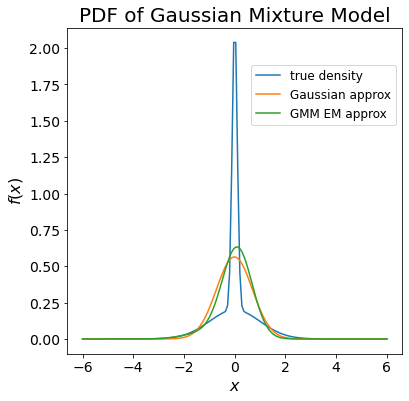

In [394]:
fig = plt.figure(figsize=(6,6))

loc=0
p=0.5
scale1=1
scale2=0.1
x_sample = sample_GMM(size=10000, loc=loc, p=p, scale1=scale1, scale2=scale2)

# real density
x_range = np.linspace(-6,6,150)
pdf_true_vals = [calc_pdf_GMM(x, loc=loc, p=p, scale1=scale1, scale2=scale2) for x in x_range]

# bad Gaussian approx
dist_badG = calc_dist_badG(x_sample)
pdf_badG_vals = [dist_badG.pdf(x) for x in x_range]

# good EM algorithm
gm = GaussianMixture(n_components=2, random_state=6, covariance_type='spherical').fit(x_sample.reshape(-1,1))
pdf_goodEM_vals = [calc_pdf_goodEM(x, gm) for x in x_range]

plt.plot(x_range, pdf_true_vals, label='true density')
plt.plot(x_range, pdf_badG_vals, label='Gaussian approx')
plt.plot(x_range, pdf_goodEM_vals, label='GMM EM approx')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('PDF of Gaussian Mixture Model', fontsize=20)
plt.legend(fontsize=12, loc=(0.55,0.7))

plt.show()

In [395]:
gm.weights_

array([0.90908461, 0.09091539])

In [396]:
gm.means_

array([[ 0.10017357],
       [-1.13669604]])

In [397]:
gm.covariances_

array([0.3430132 , 0.67685146])

### compute KL divergence

In [398]:
n = 10000

In [399]:
KL_badG = -1/n * np.sum(np.log(dist_badG.pdf(x_sample)))
KL_badG

1.0721696064230886

In [400]:
KL_goodEM = -1/n * np.sum(np.log(calc_pdf_goodEM(x_sample, gm)))
KL_goodEM

1.0469205244283175

# ii. GMM with 2 different means
# $X \sim 0.9N(0,1) + 0.1N(4,1)$

In [405]:
def sample_GMM(size=10000, p=0.9, loc1=0, loc2=4, scale=1, seed=6):
    np.random.seed(seed)
    ind_mix1 = np.random.binomial(n=1, p=p, size=size)
    mix1 = np.random.normal(loc=loc1, scale=scale, size=size)
    mix2 = np.random.normal(loc=loc2, scale=scale, size=size)
    x_sample = ind_mix1*mix1 + (1-ind_mix1)*mix2
    return x_sample

In [406]:
def calc_pdf_GMM(x, p=0.9, loc1=0, loc2=4, scale=1):
    pdf = p*norm.pdf(x=x, loc=loc1, scale=scale) + (1-p)*norm.pdf(x=x, loc=loc2, scale=scale)
    return pdf

In [407]:
def calc_dist_badG(x_sample):
    dist = norm(loc=x_sample.mean(), scale=np.sqrt(x_sample.var()))
    return dist

In [408]:
def calc_pdf_goodEM(x, gm):
    p = gm.weights_[0]
    loc1 = gm.means_[0]
    loc2 = gm.means_[1]
    scale1 = np.sqrt(gm.covariances_[0])
    scale2 = np.sqrt(gm.covariances_[1])
    pdf = p*norm.pdf(x=x, loc=loc1, scale=scale1) + (1-p)*norm.pdf(x=x, loc=loc2, scale=scale2)
    return pdf

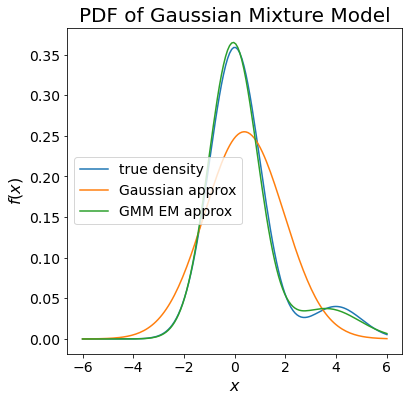

In [421]:
fig = plt.figure(figsize=(6,6))

loc1=0
loc2=4
p=0.9
x_sample = sample_GMM(size=10000, p=0.9, loc1=0, loc2=4, scale=1)

# real density
x_range = np.linspace(-6,6,150)
pdf_true_vals = [calc_pdf_GMM(x, p=0.9, loc1=0, loc2=4, scale=1) for x in x_range]

# bad Gaussian approx
dist_badG = calc_dist_badG(x_sample)
pdf_badG_vals = [dist_badG.pdf(x) for x in x_range]

# good EM algorithm
gm = GaussianMixture(n_components=2, random_state=6, covariance_type='spherical').fit(x_sample.reshape(-1,1))
pdf_goodEM_vals = [calc_pdf_goodEM(x, gm) for x in x_range]

plt.plot(x_range, pdf_true_vals, label='true density')
plt.plot(x_range, pdf_badG_vals, label='Gaussian approx')
plt.plot(x_range, pdf_goodEM_vals, label='GMM EM approx')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('PDF of Gaussian Mixture Model', fontsize=20)
plt.legend(fontsize=14)

plt.show()

In [422]:
gm.weights_

array([0.88052915, 0.11947085])

In [423]:
gm.means_

array([[-0.06214433],
       [ 3.62800293]])

In [424]:
gm.covariances_

array([0.9289504 , 1.63642766])

### compute KL divergence

In [425]:
n = 10000

In [426]:
KL_badG = -1/n * np.sum(np.log(dist_badG.pdf(x_sample)))
KL_badG

1.8661588502313826

In [427]:
KL_goodEM = -1/n * np.sum(np.log(calc_pdf_goodEM(x_sample, gm)))
KL_goodEM

1.7098045424312998

# GMM with 3 different means
# $X \sim 0.8N(0,1) + 0.1N(3,1) + 0.1N(4,1)$

In [430]:
def sample_GMM(size=10000, p1=0.8, p2=0.1, loc1=0, loc2=3, loc3=4, seed=6):
    np.random.seed(seed)
    ind_mix1 = np.random.binomial(n=1, p=p1, size=size)
    ind_mix2 = np.random.binomial(n=1, p=p2, size=size) * (1 - ind_mix1)
    ind_mix3 = 1 - ind_mix1 - ind_mix2
    mix1 = np.random.normal(loc=loc1, scale=1, size=size)
    mix2 = np.random.normal(loc=loc2, scale=1, size=size)
    mix3 = np.random.normal(loc=loc3, scale=1, size=size)
    x_sample = ind_mix1*mix1 + ind_mix2*mix2 + ind_mix3*mix3
    return x_sample

In [445]:
def calc_pdf_GMM(x, p1=0.8, p2=0.1, loc1=0, loc2=3, loc3=4):
    pdf = p1*norm.pdf(x=x, loc=loc1, scale=1) + p2*norm.pdf(x=x, loc=loc2, scale=1) + \
        (1-p1-p2)*norm.pdf(x=x, loc=loc3, scale=1)
    return pdf

In [503]:
def calc_pdf_tricky(x, loc=1.8, scale=2.2):
    pdf = norm.pdf(x=x, loc=loc, scale=scale)
    return pdf

In [447]:
def calc_dist_badG(x_sample):
    dist = norm(loc=x_sample.mean(), scale=np.sqrt(x_sample.var()))
    return dist

In [527]:
def calc_pdf_goodEM(x, gm):
    p1 = gm.weights_[0]
    p2 = gm.weights_[1]
    loc1 = gm.means_[0]
    loc2 = gm.means_[1]
    loc3 = gm.means_[2]
    scale1 = np.sqrt(gm.covariances_[0])
    scale2 = np.sqrt(gm.covariances_[1])
    scale3 = np.sqrt(gm.covariances_[2])
    pdf = p1*norm.pdf(x=x, loc=loc1, scale=scale1) + p2*norm.pdf(x=x, loc=loc2, scale=scale2) + \
        (1-p1-p2)*norm.pdf(x=x, loc=loc3, scale=scale3)
    return pdf

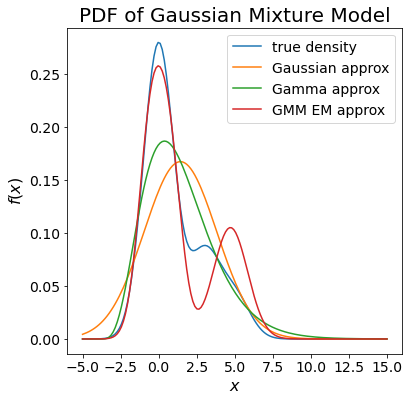

In [528]:
fig = plt.figure(figsize=(6,6))

loc1=0
loc2=3
loc3=5
p1=0.7
p2=0.2
x_sample = sample_GMM(size=10000, loc1=loc1, loc2=loc2, loc3=loc3, p1=p1, p2=p2)

# real density
x_range = np.linspace(-5,15,150)
pdf_true_vals = [calc_pdf_GMM(x, loc1=loc1, loc2=loc2, loc3=loc3, p1=p1, p2=p2) for x in x_range]

# bad Gaussian approx
dist_badG = calc_dist_badG(x_sample)
pdf_badG_vals = [dist_badG.pdf(x) for x in x_range]

# bad Gamma approx
fit_a, fit_loc, fit_scale = gamma.fit(x_sample)
pdf_gamma_vals = [gamma.pdf(x=x, a=fit_a, loc=fit_loc, scale=fit_scale) for x in x_range]

# good EM algorithm
gm = GaussianMixture(n_components=3, random_state=6, covariance_type='spherical').fit(x_sample.reshape(-1,1))
pdf_goodEM_vals = [calc_pdf_goodEM(x, gm) for x in x_range]

plt.plot(x_range, pdf_true_vals, label='true density')
plt.plot(x_range, pdf_badG_vals, label='Gaussian approx')
plt.plot(x_range, pdf_gamma_vals, label='Gamma approx')
plt.plot(x_range, pdf_goodEM_vals, label='GMM EM approx')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('PDF of Gaussian Mixture Model', fontsize=20)
plt.legend(fontsize=14)

plt.show()

In [529]:
gm.weights_

array([0.31678946, 0.29741383, 0.38579671])

In [530]:
gm.means_

array([[ 0.73111692],
       [ 4.7173727 ],
       [-0.52895449]])

In [531]:
gm.covariances_

array([0.62687536, 1.27190982, 0.65457319])

### compute KL divergence

In [522]:
n = 10000

In [532]:
KL_badG = -1/n * np.sum(np.log(dist_badG.pdf(x_sample)))
KL_badG

2.2873020991600113

In [533]:
KL_gamma = -1/n * np.sum(np.log(gamma.pdf(x=x_sample, a=fit_a, loc=fit_loc, scale=fit_scale)))
KL_gamma

2.1982995869484125

In [534]:
KL_goodEM = -1/n * np.sum(np.log(calc_pdf_goodEM(x_sample, gm)))
KL_goodEM

2.0427022981847553

In [535]:
-1/n * np.sum(np.log(calc_pdf_GMM(x_sample)))

2.2308038802711394